# Customer analysis in marketing campaigns

In this exercise, you work for a consulting firm as data scientist. In this scenario, your client is the marketing team of a grocery store. They would like to find which are the ideal customers according to the results of the last marketing campaigns. Your analysis will be helpful to adapt and modify products according to the different needs and behavior of their customers.

You dispose of a dataset from the mall dataset with several features:


People

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if customer complained in the last 2 years, 0 otherwise

Products

- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

Promotion

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place

- NumWebPurchases: Number of purchases made through the company’s web site
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s web site in the last month

'Z_CostContact' and 'Z_Revenue' contains constant value across all the observations and therefore they will not contribute anything in the analysis.

You have two days to do this study

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [139]:
campaign_df = pd.read_csv('../data/marketing_campaign.csv', sep="\t")
campaign_df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [140]:
campaign_df=campaign_df.drop(columns=['Z_CostContact','Z_Revenue'], axis=1)

# EDA

In [141]:
campaign_df['Dt_Customer'] = campaign_df['Dt_Customer'].apply(pd.to_datetime)

In [142]:
campaign_df = campaign_df.drop([239,339,192,2233],axis=0)

In [143]:
campaign_df.dropna(axis=0,inplace=True)

##### Duplicats

In [144]:
duplicats=campaign_df.drop('ID',axis=1)[campaign_df.drop('ID',axis=1).duplicated()==True].index

In [145]:
campaign_df = campaign_df.drop(duplicats,axis=0)

In [146]:
duplicats2=campaign_df.drop(["Response","ID"],axis=1)[campaign_df.drop(["Response","ID"],axis=1).duplicated()==True].index

In [147]:
campaign_df = campaign_df.drop(duplicats2,axis=0)

##### Pairplots

### Encoding

In [148]:
campaign_df = campaign_df.drop(campaign_df[campaign_df['Marital_Status']=='Absurd'].index,axis=0)
campaign_df = campaign_df.drop(campaign_df[campaign_df['Marital_Status']=='YOLO'].index,axis=0)

In [149]:
campaign_df = campaign_df.replace('Alone','Single')

In [150]:
campaign_df.reset_index(inplace=True)

In [151]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = enc.fit(campaign_df[['Education']])
enc_df = pd.DataFrame(enc.transform(campaign_df[['Education']]).toarray())
enc_df.columns = ['2n Cycle', 'Basic','Graduation', 'Master','PhD']

In [152]:
campaign_df = campaign_df.merge(enc_df, on=campaign_df.index)
campaign_df = campaign_df.drop(['Education', 'key_0'], axis=1)

In [153]:
enc2 = OneHotEncoder(handle_unknown='ignore')
enc_df2 = enc2.fit(campaign_df[['Marital_Status']])
enc_df2 = pd.DataFrame(enc2.transform(campaign_df[['Marital_Status']]).toarray())
enc_df2.columns = ['Divorced','Married','Single', 'Together','Widow']

In [154]:
campaign_df = campaign_df.merge(enc_df2, on=campaign_df.index)
campaign_df = campaign_df.drop(['Marital_Status', 'key_0'], axis=1)

In [155]:
campaign_df = campaign_df.drop('index', axis=1)

In [156]:
campaign_df

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow
0,5524,1957,58138.0,0,0,2012-04-09,58,635,88,546,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2174,1954,46344.0,1,1,2014-08-03,38,11,1,6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6182,1984,26646.0,1,0,2014-10-02,26,11,4,20,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,8080,1986,26816.0,0,0,2012-08-17,50,5,1,6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2004,10870,1967,61223.0,0,1,2013-06-13,46,709,43,182,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2005,7270,1981,56981.0,0,0,2014-01-25,91,908,48,217,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2006,8235,1956,69245.0,0,1,2014-01-24,8,428,30,214,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [121]:
#campaign_df.to_csv('campaign_df_no_scal.csv', index=False

In [157]:
cdf = campaign_df

### Scaling

In [122]:
Xmms = campaign_df.drop(['ID','2n Cycle','Basic','Graduation','Master','PhD','Divorced','Married','Single','Together','Widow','Kidhome','Teenhome','Complain','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2','Dt_Customer','Response'], axis=1)

In [123]:
mms = MinMaxScaler()
ft_mms = mms.fit(Xmms)
campaign_df_mms = ft_mms.transform(Xmms)
campaign_df_mms = pd.DataFrame(campaign_df_mms, columns=Xmms.columns)

In [124]:
campaign_df_mms

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,0.303571,0.351086,0.585859,0.425318,0.442211,0.316522,0.664093,0.335878,0.274143,0.200000,0.296296,0.357143,0.307692,0.35
1,0.250000,0.277680,0.383838,0.007368,0.005025,0.003478,0.007722,0.003817,0.018692,0.133333,0.037037,0.035714,0.153846,0.25
2,0.446429,0.434956,0.262626,0.285332,0.246231,0.073623,0.428571,0.080153,0.130841,0.066667,0.296296,0.071429,0.769231,0.20
3,0.785714,0.155079,0.262626,0.007368,0.020101,0.011594,0.038610,0.011450,0.015576,0.133333,0.074074,0.000000,0.307692,0.30
4,0.732143,0.352051,0.949495,0.115874,0.216080,0.068406,0.177606,0.103053,0.046729,0.333333,0.185185,0.107143,0.461538,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,0.821429,0.156137,0.505051,0.003349,0.005025,0.003478,0.011583,0.015267,0.009346,0.066667,0.000000,0.000000,0.230769,0.20
2004,0.482143,0.370288,0.464646,0.474883,0.216080,0.105507,0.162162,0.450382,0.769470,0.133333,0.333333,0.107143,0.307692,0.25
2005,0.732143,0.343885,0.919192,0.608171,0.241206,0.125797,0.123552,0.045802,0.074766,0.066667,0.074074,0.107143,1.000000,0.30
2006,0.285714,0.420217,0.080808,0.286671,0.150754,0.124058,0.308880,0.114504,0.190031,0.133333,0.222222,0.178571,0.769231,0.15


In [125]:
campaign_df

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow
0,5524,1957,58138.0,0,0,2012-04-09,58,635,88,546,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2174,1954,46344.0,1,1,2014-08-03,38,11,1,6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6182,1984,26646.0,1,0,2014-10-02,26,11,4,20,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,8080,1986,26816.0,0,0,2012-08-17,50,5,1,6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2004,10870,1967,61223.0,0,1,2013-06-13,46,709,43,182,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2005,7270,1981,56981.0,0,0,2014-01-25,91,908,48,217,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2006,8235,1956,69245.0,0,1,2014-01-24,8,428,30,214,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [126]:
campaign_df = campaign_df.merge(campaign_df_mms, on=campaign_df.index)
campaign_df = campaign_df.drop(['Year_Birth_x','Income_x','Recency_x','MntWines_x','MntFruits_x','MntMeatProducts_x','MntFishProducts_x','MntSweetProducts_x','MntGoldProds_x','NumDealsPurchases_x','NumWebPurchases_x','NumCatalogPurchases_x','NumStorePurchases_x','NumWebVisitsMonth_x', 'key_0'], axis=1)

In [127]:
campaign_df

,ID,Kidhome,Teenhome,Dt_Customer,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,...,MntFruits_y,MntMeatProducts_y,MntFishProducts_y,MntSweetProducts_y,MntGoldProds_y,NumDealsPurchases_y,NumWebPurchases_y,NumCatalogPurchases_y,NumStorePurchases_y,NumWebVisitsMonth_y
0,5524,0,0,2012-04-09,0,0,0,0,0,0,...,0.442211,0.316522,0.664093,0.335878,0.274143,0.200000,0.296296,0.357143,0.307692,0.35
1,2174,1,1,2014-08-03,0,0,0,0,0,0,...,0.005025,0.003478,0.007722,0.003817,0.018692,0.133333,0.037037,0.035714,0.153846,0.25
2,4141,0,0,2013-08-21,0,0,0,0,0,0,...,0.246231,0.073623,0.428571,0.080153,0.130841,0.066667,0.296296,0.071429,0.769231,0.20
3,6182,1,0,2014-10-02,0,0,0,0,0,0,...,0.020101,0.011594,0.038610,0.011450,0.015576,0.133333,0.074074,0.000000,0.307692,0.30
4,5324,1,0,2014-01-19,0,0,0,0,0,0,...,0.216080,0.068406,0.177606,0.103053,0.046729,0.333333,0.185185,0.107143,0.461538,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,8080,0,0,2012-08-17,0,0,0,0,0,0,...,0.005025,0.003478,0.011583,0.015267,0.009346,0.066667,0.000000,0.000000,0.230769,0.20
2004,10870,0,1,2013-06-13,0,0,0,0,0,0,...,0.216080,0.105507,0.162162,0.450382,0.769470,0.133333,0.333333,0.107143,0.307692,0.25
2005,7270,0,0,2014-01-25,0,1,0,0,0,0,...,0.241206,0.125797,0.123552,0.045802,0.074766,0.066667,0.074074,0.107143,1.000000,0.30
2006,8235,0,1,2014-01-24,0,0,0,0,0,0,...,0.150754,0.124058,0.308880,0.114504,0.190031,0.133333,0.222222,0.178571,0.769231,0.15


### Correlations

In [128]:
X = campaign_df.drop('ID', axis=1)
Xcorr = campaign_df.drop(['ID','Dt_Customer'], axis=1)

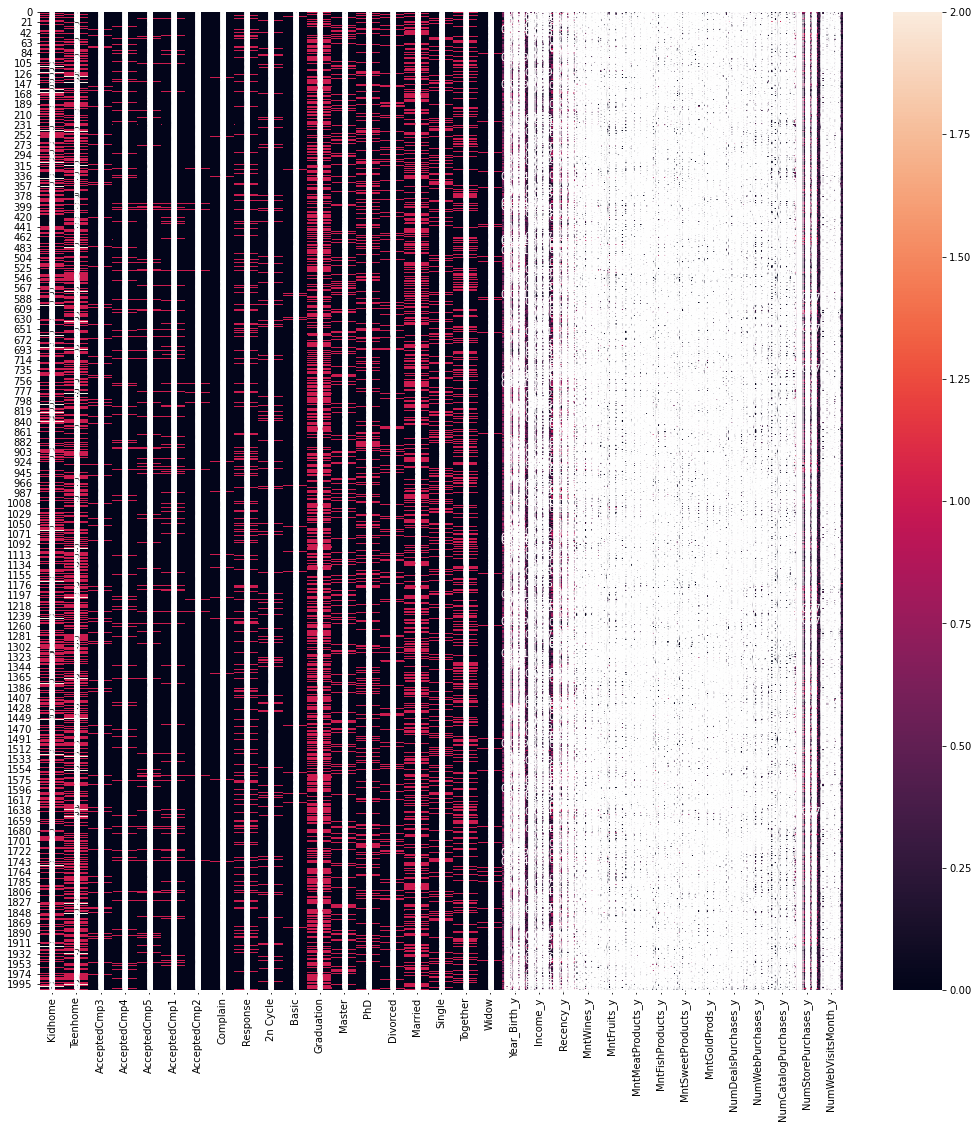

In [129]:
campaign_df_corr = Xcorr.corr()
plt.figure(figsize=(18,18))
sns.heatmap(Xcorr, annot=True)
plt.show()

# Customer Segmentation

In [130]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

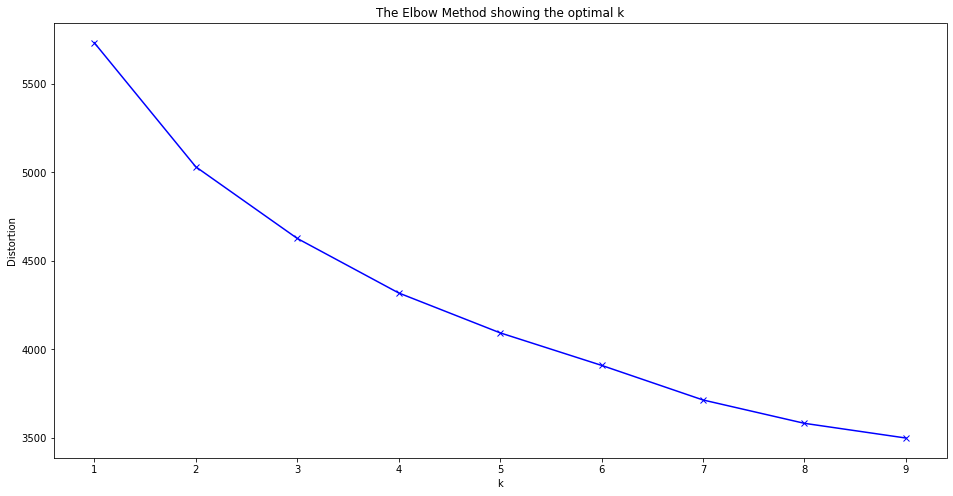

In [131]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(Xcorr)
    distortions.append(kmeanModel.inertia_)

plt.subplots(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [132]:
kmeanModel2 = KMeans(n_clusters=2)
kmeanModel2.fit(Xcorr)

KMeans(n_clusters=2)

In [133]:
kmeanModel3 = KMeans(n_clusters=3)
kmeanModel3.fit(Xcorr)

KMeans(n_clusters=3)

In [134]:
print(silhouette_score(Xcorr, kmeanModel2.labels_, metric='euclidean'))
print(silhouette_score(Xcorr, kmeanModel3.labels_, metric='euclidean'))

0.11976250769752199
0.12549859326946688


In [135]:
#uniquement les vaiables qtitatives : 
0.6017882659412467 # 2 clusters
0.5425378110832533 # 3 clusters

0.5425378110832533

In [136]:
campaign_df['kmeans'] = kmeanModel3.predict(Xmms)

ValueError: X has 14 features, but KMeans is expecting 33 features as input.

In [ ]:
sns.pairplot(campaign_df, hue='kmeans')

In [ ]:
campaign_df.to_csv('campaign_df.csv', index=False)

# Conlusions

In [159]:
cdf = cdf.drop('ID', axis=1)

In [162]:
cdf

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow
0,1957,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1954,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1965,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1984,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1981,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,1986,26816.0,0,0,2012-08-17,50,5,1,6,3,4,3,1,0,0,3,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2004,1967,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2005,1981,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2006,1956,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [161]:
pd.set_option('display.max_columns', None)

In [165]:
cdf['mnt_tot'] = cdf.MntWines + cdf.MntFruits + cdf.MntMeatProducts + cdf.MntFishProducts + cdf.MntSweetProducts

In [166]:
cdf['nb_achats'] = cdf.NumDealsPurchases + cdf.NumWebPurchases + cdf.NumCatalogPurchases + cdf.NumStorePurchases

In [172]:
cdf[(cdf['AcceptedCmp1']!=1) & (cdf['AcceptedCmp2']!=1) & (cdf['AcceptedCmp3']!=1) & (cdf['AcceptedCmp4']!=1) & (cdf['AcceptedCmp5']!=1) & (cdf['Response']!=1)]

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow,mnt_tot,nb_achats
1,1954,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21,6
2,1965,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734,21
3,1984,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48,8
4,1981,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,407,19
5,1967,62513.0,0,1,2013-09-09,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,702,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,1972,24434.0,2,0,2014-05-18,9,3,2,8,20,0,17,2,2,1,2,7,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,33,7
2002,1970,44802.0,0,0,2012-08-21,71,853,10,143,13,10,20,2,9,4,12,8,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1029,27
2003,1986,26816.0,0,0,2012-08-17,50,5,1,6,3,4,3,1,0,0,3,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,4
2004,1967,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1094,18


In [175]:
index_cl = cdf[(cdf['AcceptedCmp1']!=1) & (cdf['AcceptedCmp2']!=1) & (cdf['AcceptedCmp3']!=1) & (cdf['AcceptedCmp4']!=1) & (cdf['AcceptedCmp5']!=1) & (cdf['Response']!=1)].index

In [176]:
campaign_cl = cdf.drop(index_cl, axis=0)

In [177]:
campaign_cl

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow,mnt_tot,nb_achats
0,1957,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1529,25
8,1974,30351.0,1,0,2013-06-06,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,44,6
9,1950,5648.0,1,1,2014-03-13,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,36,2
14,1946,82800.0,0,0,2012-11-24,23,1006,22,115,59,68,45,1,7,6,12,3,0,0,1,1,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1270,26
17,1949,76995.0,0,1,2013-03-28,91,1012,80,498,0,16,176,2,11,4,9,5,0,0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1606,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,1954,32144.0,1,1,2014-03-23,76,41,0,10,0,0,3,4,2,1,3,7,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,51,10
1997,1970,57642.0,0,1,2014-09-01,24,580,6,58,8,0,27,3,7,6,6,4,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,652,22
2001,1984,11012.0,1,0,2013-03-16,82,24,3,26,7,1,23,3,3,1,2,9,1,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,61,9
2005,1981,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1217,19


In [178]:
rfm = campaign_cl[['Recency','mnt_tot','nb_achats']]

In [179]:
rfm.describe()

,Recency,mnt_tot,nb_achats
count,551.000000,551.000000,551.000000
mean,44.079855,935.635209,18.005445
std,29.340586,662.800471,6.804943
min,0.000000,8.000000,2.000000
25%,18.000000,300.500000,14.000000
50%,40.000000,957.000000,19.000000
75%,70.000000,1492.000000,23.000000
max,99.000000,2491.000000,35.000000


In [180]:
rfm['R'] = -1
rfm['F'] = -2
rfm['M'] = -3

<ipython-input-180-b8096c093fbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['R'] = -1
<ipython-input-180-b8096c093fbf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['F'] = -2
<ipython-input-180-b8096c093fbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [199]:
for i in range(0,len(rfm.index)):
    if rfm['nb_achats'].iloc[i]>=23:
        rfm['F'].iloc[i]=1
    elif (rfm['nb_achats'].iloc[i]>14) & (rfm['nb_achats'].iloc[i]<23):
        rfm['F'].iloc[i]=2
    elif rfm['nb_achats'].iloc[i]<=14:
        rfm['F'].iloc[i]=3

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [192]:
for i in range(0,len(rfm.index)):
    if rfm['mnt_tot'].iloc[i]>=1492:
        rfm['M'].iloc[i]=1
    elif (rfm['mnt_tot'].iloc[i]<1492) & (rfm['mnt_tot'].iloc[i]>300):
        rfm['M'].iloc[i]=2
    elif rfm['mnt_tot'].iloc[i]<=300:
        rfm['M'].iloc[i]=3

In [193]:
for i in range(0,len(rfm.index)):
    if rfm['Recency'].iloc[i]<=30:
        rfm['R'].iloc[i]=1
    elif (rfm['Recency'].iloc[i]>30) & (rfm['Recency'].iloc[i]<=60):
        rfm['R'].iloc[i]=2
    elif rfm['Recency'].iloc[i]>60:
        rfm['R'].iloc[i]=3

In [200]:
rfm

,Recency,mnt_tot,nb_achats,R,F,M,Score_RFM
0,58,1529,25,2,1,1,-1
8,19,44,6,1,3,3,-1
9,68,36,2,3,3,3,-1
14,23,1270,26,1,1,2,-1
17,91,1606,26,3,1,1,-1
...,...,...,...,...,...,...,...
1984,76,51,10,3,3,3,-1
1997,24,652,22,1,2,2,-1
2001,82,61,9,3,3,3,-1
2005,91,1217,19,3,2,2,-1


In [189]:
rfm['Score_RFM'] =-1

<ipython-input-189-f02576e91653>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['Score_RFM'] =-1


In [202]:
for i in range(0,len(rfm.index)):
    if (rfm['R'].iloc[i]==1) & (rfm['F'].iloc[i]==1) & (rfm['M'].iloc[i]==1):
        rfm['Score_RFM'].iloc[i]='Top'
    elif (rfm['R'].iloc[i]==2) & (rfm['F'].iloc[i]==1) & (rfm['M'].iloc[i]==1):
        rfm['Score_RFM'].iloc[i]='Bon client en perte'
    elif (rfm['R'].iloc[i]==3) & (rfm['F'].iloc[i]==1) & (rfm['M'].iloc[i]==2):
        rfm['Score_RFM'].iloc[i]='Bon client perdu'
    elif (rfm['R'].iloc[i]==1) & (rfm['F'].iloc[i]==3):
        rfm['Score_RFM'].iloc[i]='Un achat'
    else:
        rfm['Score_RFM'].iloc[i]='Moyen'

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [206]:
rfm['Score_RFM'].value_counts()

Moyen                  431
Un achat                65
Bon client perdu        26
Bon client en perte     18
Top                     11
Name: Score_RFM, dtype: int64

In [219]:
cdf['campaign'] = 1

In [221]:
cdf[(cdf['AcceptedCmp1']!=1) & (cdf['AcceptedCmp2']!=1) & (cdf['AcceptedCmp3']!=1) & (cdf['AcceptedCmp4']!=1) & (cdf['AcceptedCmp5']!=1) & (cdf['Response']!=1)]

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow,mnt_tot,nb_achats,campaign
1,1954,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21,6,1
2,1965,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734,21,1
3,1984,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48,8,1
4,1981,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,407,19,1
5,1967,62513.0,0,1,2013-09-09,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,702,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,1972,24434.0,2,0,2014-05-18,9,3,2,8,20,0,17,2,2,1,2,7,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,33,7,1
2002,1970,44802.0,0,0,2012-08-21,71,853,10,143,13,10,20,2,9,4,12,8,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1029,27,1
2003,1986,26816.0,0,0,2012-08-17,50,5,1,6,3,4,3,1,0,0,3,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,4,1
2004,1967,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1094,18,1


In [225]:
cdf

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow,mnt_tot,nb_achats,campaign
0,1957,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1529,25,1
1,1954,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21,6,1
2,1965,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734,21,1
3,1984,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48,8,1
4,1981,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,407,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,1986,26816.0,0,0,2012-08-17,50,5,1,6,3,4,3,1,0,0,3,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,4,1
2004,1967,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1094,18,1
2005,1981,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1217,19,1
2006,1956,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,782,23,1


In [228]:
cdf[(cdf['AcceptedCmp1']!=1) & (cdf['AcceptedCmp2']!=1) & (cdf['AcceptedCmp3']!=1) & (cdf['AcceptedCmp4']!=1) & (cdf['AcceptedCmp5']!=1) & (cdf['Response']!=1)]

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow,mnt_tot,nb_achats,campaign
1,1954,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21,6,1
2,1965,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734,21,1
3,1984,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48,8,1
4,1981,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,407,19,1
5,1967,62513.0,0,1,2013-09-09,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,702,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,1972,24434.0,2,0,2014-05-18,9,3,2,8,20,0,17,2,2,1,2,7,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,33,7,1
2002,1970,44802.0,0,0,2012-08-21,71,853,10,143,13,10,20,2,9,4,12,8,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1029,27,1
2003,1986,26816.0,0,0,2012-08-17,50,5,1,6,3,4,3,1,0,0,3,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,4,1
2004,1967,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1094,18,1


In [230]:
for i in range(0,len(cdf.index)):
    if ((cdf['AcceptedCmp1'].iloc[i]!=1) & (cdf['AcceptedCmp2'].iloc[i]!=1) & (cdf['AcceptedCmp3'].iloc[i]!=1) & (cdf['AcceptedCmp4'].iloc[i]!=1) & (cdf['AcceptedCmp5'].iloc[i]!=1) & (cdf['Response'].iloc[i]!=1)):
        cdf['campaign'].iloc[i] = 0

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [231]:
cdf

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow,mnt_tot,nb_achats,campaign
0,1957,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1529,25,1
1,1954,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21,6,0
2,1965,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734,21,0
3,1984,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48,8,0
4,1981,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,407,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,1986,26816.0,0,0,2012-08-17,50,5,1,6,3,4,3,1,0,0,3,4,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,4,0
2004,1967,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1094,18,0
2005,1981,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1217,19,1
2006,1956,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,782,23,0


In [232]:
rfm_tot = cdf[['Recency','mnt_tot','nb_achats','campaign']]

In [233]:
rfm_tot.describe()

,Recency,mnt_tot,nb_achats,campaign
count,2008.000000,2008.000000,2008.000000,2008.000000
mean,49.016434,563.505478,14.884462,0.274402
std,28.956081,577.149160,7.656853,0.446324
min,0.000000,4.000000,0.000000,0.000000
25%,24.000000,55.000000,8.000000,0.000000
50%,49.000000,342.500000,15.000000,0.000000
75%,74.000000,962.000000,21.000000,1.000000
max,99.000000,2491.000000,44.000000,1.000000


In [236]:
rfm_tot['R'] = -1
rfm_tot['F'] = -2
rfm_tot['M'] = -3

<ipython-input-236-12c63934a179>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_tot['R'] = -1
<ipython-input-236-12c63934a179>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_tot['F'] = -2
<ipython-input-236-12c63934a179>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [237]:
for i in range(0,len(rfm_tot.index)):
    if rfm_tot['nb_achats'].iloc[i]>=21:
        rfm_tot['F'].iloc[i]=1
    elif (rfm_tot['nb_achats'].iloc[i]>8) & (rfm_tot['nb_achats'].iloc[i]<21):
        rfm_tot['F'].iloc[i]=2
    elif rfm_tot['nb_achats'].iloc[i]<=8:
        rfm_tot['F'].iloc[i]=3

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [238]:
for i in range(0,len(rfm_tot.index)):
    if rfm_tot['mnt_tot'].iloc[i]>=962:
        rfm_tot['M'].iloc[i]=1
    elif (rfm_tot['mnt_tot'].iloc[i]<962) & (rfm_tot['mnt_tot'].iloc[i]>55):
        rfm_tot['M'].iloc[i]=2
    elif rfm_tot['mnt_tot'].iloc[i]<=55:
        rfm_tot['M'].iloc[i]=3

In [239]:
for i in range(0,len(rfm_tot.index)):
    if rfm_tot['Recency'].iloc[i]<=30:
        rfm_tot['R'].iloc[i]=1
    elif (rfm_tot['Recency'].iloc[i]>30) & (rfm_tot['Recency'].iloc[i]<=60):
        rfm_tot['R'].iloc[i]=2
    elif rfm_tot['Recency'].iloc[i]>60:
        rfm_tot['R'].iloc[i]=3

In [245]:
rfm_tot['Score_RFM'] =-1

<ipython-input-245-ba0e0ad63ae2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_tot['Score_RFM'] =-1


In [243]:
rfm_tot

,Recency,mnt_tot,nb_achats,campaign,R,F,M
0,58,1529,25,1,2,1,1
1,38,21,6,0,2,3,3
2,26,734,21,0,1,1,2
3,26,48,8,0,1,3,3
4,94,407,19,0,3,2,2
...,...,...,...,...,...,...,...
2003,50,19,4,0,2,3,3
2004,46,1094,18,0,2,2,1
2005,91,1217,19,1,3,2,1
2006,8,782,23,0,1,1,2


In [246]:
for i in range(0,len(rfm.index)):
    if (rfm_tot['R'].iloc[i]==1) & (rfm_tot['F'].iloc[i]==1) & (rfm_tot['M'].iloc[i]==1):
        rfm_tot['Score_RFM'].iloc[i]='Top'
    elif (rfm_tot['R'].iloc[i]==2) & (rfm_tot['F'].iloc[i]==1) & (rfm_tot['M'].iloc[i]==1):
        rfm_tot['Score_RFM'].iloc[i]='Bon client peu regulier'
    elif (rfm_tot['R'].iloc[i]==3) & (rfm_tot['F'].iloc[i]==1) & (rfm_tot['M'].iloc[i]==2):
        rfm_tot['Score_RFM'].iloc[i]='Bon client en perte'
    else:
        rfm_tot['Score_RFM'].iloc[i]='Moyen'

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [252]:
rfm_tot['Score_RFM'].value_counts()

-1                         1457
Moyen                       482
Top                          25
Bon client peu regulier      24
Bon client en perte          20
Name: Score_RFM, dtype: int64

In [254]:
campaign = cdf[cdf['campaign']==1]

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Income'>

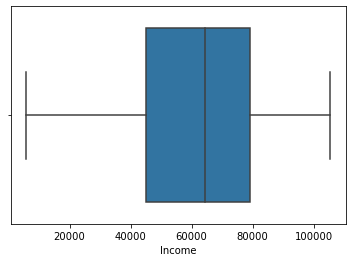

In [257]:
sns.boxplot(cdf[cdf['campaign']==1]['Income'])

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Income'>

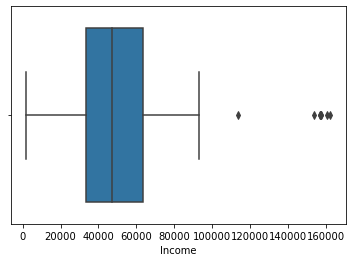

In [259]:
sns.boxplot(cdf[cdf['campaign']==0]['Income'])

In [271]:
campaign_brut = pd.read_csv('../data/campaign_df_noscal_noencod.csv')
campaign_brut = campaign_brut.drop(['Unnamed: 0','index','ID'], axis=1)

In [272]:
campaign_brut['campaign']=1
for i in range(0,len(campaign_brut.index)):
    if ((campaign_brut['AcceptedCmp1'].iloc[i]!=1) & (campaign_brut['AcceptedCmp2'].iloc[i]!=1) & (campaign_brut['AcceptedCmp3'].iloc[i]!=1) & (campaign_brut['AcceptedCmp4'].iloc[i]!=1) & (campaign_brut['AcceptedCmp5'].iloc[i]!=1) & (campaign_brut['Response'].iloc[i]!=1)):
        campaign_brut['campaign'].iloc[i] = 0

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [284]:
campaign_brut[campaign_brut['campaign']==1]['age'].value_counts()/len(campaign_brut[campaign_brut['campaign']==1])*100

Married     35.753176
Single      25.226860
Together    23.593466
Divorced    10.889292
Widow        4.537205
Name: Marital_Status, dtype: float64

In [292]:
(campaign_brut[campaign_brut['campaign']==0]['TeenHome'].value_counts()/len(campaign_brut[campaign_brut['campaign']==0])*100)

KeyError: 'TeenHome'

In [291]:
campaign_brut[campaign_brut['campaign']==1]['age'].mean()

45.62613430127042

In [290]:
campaign_brut[campaign_brut['campaign']==0]['age'].mean()

44.93136582017845

In [ ]:
df_good["Age"] = 2014 - df_good["Year_Birth"]
df_good.drop("Year_Birth", axis=1, inplace=True)

In [286]:
campaign_brut['age'] = 2014 - campaign_brut["Year_Birth"]

In [296]:
df = pd.concat([rfm_tot,campaign_brut], axis=1)

In [301]:
len(df[df['Score_RFM']=="Top"])

25

In [303]:
sns.pairplot(df, hue=df['campaign'])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [306]:
df[df['Score_RFM']=="Top"].describe()

,Recency,mnt_tot,nb_achats,campaign,R,F,M,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,campaign,age
count,25.000000,25.000000,25.000000,25.000000,25.0,25.0,25.0,25.000000,25.000000,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0,25.000000,25.000000,25.000000
mean,14.320000,1345.680000,24.600000,0.560000,1.0,1.0,1.0,1966.880000,73550.440000,0.0,0.320000,14.320000,764.480000,52.280000,386.920000,80.560000,61.440000,60.520000,1.720000,6.880000,6.600000,9.40000,4.240000,0.080000,0.280000,0.280000,0.320000,0.120000,0.0,0.440000,0.560000,47.120000
std,9.026443,253.700729,4.020779,0.506623,0.0,0.0,0.0,13.131768,10468.826112,0.0,0.476095,9.026443,301.158889,52.862652,179.619719,61.536629,54.380664,56.127919,1.061446,3.032051,2.291288,2.54951,1.832121,0.276887,0.458258,0.458258,0.476095,0.331662,0.0,0.506623,0.506623,13.131768
min,1.000000,962.000000,21.000000,0.000000,1.0,1.0,1.0,1945.000000,53653.000000,0.0,0.000000,1.000000,168.000000,0.000000,115.000000,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000,5.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,20.000000
25%,8.000000,1206.000000,21.000000,0.000000,1.0,1.0,1.0,1955.000000,66465.000000,0.0,0.000000,8.000000,559.000000,19.000000,249.000000,38.000000,24.000000,24.000000,1.000000,4.000000,5.000000,8.00000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,38.000000
50%,14.000000,1352.000000,23.000000,1.000000,1.0,1.0,1.0,1966.000000,74068.000000,0.0,0.000000,14.000000,783.000000,30.000000,364.000000,59.000000,44.000000,37.000000,1.000000,7.000000,6.000000,9.00000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,48.000000
75%,21.000000,1482.000000,27.000000,1.000000,1.0,1.0,1.0,1976.000000,79946.000000,0.0,1.000000,21.000000,997.000000,61.000000,537.000000,121.000000,76.000000,102.000000,2.000000,10.000000,9.000000,12.00000,6.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,1.000000,1.000000,59.000000
max,30.000000,1958.000000,35.000000,1.000000,1.0,1.0,1.0,1994.000000,102692.000000,0.0,1.000000,30.000000,1349.000000,183.000000,780.000000,218.000000,178.000000,192.000000,5.000000,11.000000,11.000000,13.00000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,69.000000


In [305]:
df[df['Score_RFM']=="Top"]

,Recency,mnt_tot,nb_achats,campaign,R,F,M,Score_RFM,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,campaign,age
14,23,1270,26,1,1,1,1,Top,1946,PhD,Single,82800.0,0,0,2012-11-24,23,1006,22,115,59,68,45,1,7,6,12,3,0,0,1,1,0,0,1,1,68
38,3,1293,21,0,1,1,1,Top,1980,Graduation,Married,80011.0,0,1,2013-04-29,3,421,76,536,82,178,102,2,8,6,5,4,0,0,0,0,0,0,0,0,34
47,2,1661,29,0,1,1,1,Top,1964,Master,Married,79143.0,0,0,2012-11-08,2,650,37,780,27,167,32,1,6,9,13,3,0,0,0,0,0,0,0,0,50
52,30,1053,21,1,1,1,1,Top,1966,Graduation,Divorced,70287.0,0,0,2013-02-04,30,295,35,482,121,120,40,1,5,5,10,3,0,0,0,0,0,0,1,1,48
55,12,1358,21,1,1,1,1,Top,1982,Master,Single,75777.0,0,0,2013-04-07,12,712,26,538,69,13,80,1,3,6,11,1,0,1,1,0,0,0,1,1,32
62,19,1236,32,1,1,1,1,Top,1979,2n Cycle,Single,88194.0,0,1,2014-03-19,19,688,14,309,201,24,38,1,11,10,10,5,1,0,0,1,0,0,1,1,35
65,1,1241,21,0,1,1,1,Top,1954,Master,Married,66991.0,0,0,2012-11-09,1,496,36,460,189,60,12,3,4,8,6,3,0,0,0,0,0,0,0,0,60
123,21,1482,23,1,1,1,1,Top,1967,PhD,Together,62981.0,0,0,2013-03-17,21,796,14,590,38,44,0,1,4,5,13,3,0,1,0,0,0,0,0,1,47
143,10,1339,21,1,1,1,1,Top,1949,Graduation,Together,69372.0,0,0,2013-02-19,10,997,26,269,34,13,42,1,10,4,6,4,0,1,1,0,0,0,1,1,65
149,20,1673,27,0,1,1,1,Top,1945,PhD,Married,70356.0,0,0,2012-05-11,20,1349,16,249,43,16,33,2,10,6,9,6,0,0,0,0,0,0,0,0,69
